![MAIA banner](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Aprendizaje_refuerzo_profundo_Banner_V1.png)

# <h1><center>Reto 2 - Solución Completa</center></h1>

<center><h1>Robótica con Gymnasium Robotics</h1></center>

**Estudiante:** [Tu Nombre]
**Fecha:** [Fecha]

Este notebook contiene la solución completa para el Reto 2, implementando agentes de aprendizaje por refuerzo para tres ambientes de robótica diferentes:

1. **AdroitHandDoor-v1**: Manipulación de puerta con mano robótica
2. **FetchReachDense-v4**: Alcanzar objetivo con brazo robótico
3. **HandReachDense-v3**: Coordinación de dedos con mano antropomórfica

## Tabla de Contenidos
1. [Reporte Profesional](#reporte)
2. [Instalación de Dependencias](#instalacion)
3. [Configuración Base](#configuracion)
4. [AdroitHandDoor-v1 - Apertura de Puerta](#adroit)
5. [FetchReachDense-v4 - Alcanzar Objetivo](#fetch)
6. [HandReachDense-v3 - Coordinación de Dedos](#shadow)
7. [Análisis Comparativo](#analisis)
8. [Conclusiones](#conclusiones)


# 1. Reporte Profesional

## 1.1 Selección y Justificación de Algoritmos

Para este reto se seleccionaron los siguientes algoritmos basados en las características específicas de cada ambiente:

### AdroitHandDoor-v1:
- **Algoritmo Principal**: **SAC (Soft Actor-Critic)**
- **Algoritmo Secundario**: **PPO (Proximal Policy Optimization)**

**Justificación**: La tarea de abrir una puerta requiere exploración eficiente y control preciso. SAC es ideal porque:
- Maximiza tanto recompensa como entropía, favoreciendo la exploración
- Es off-policy, permitiendo mejor eficiencia de muestreo
- Maneja bien espacios de acción continuos de alta dimensionalidad (30 grados de libertad)
- Su robustez lo hace ideal para tareas de manipulación compleja

### FetchReachDense-v4:
- **Algoritmo Principal**: **TD3 (Twin Delayed Deep Deterministic Policy Gradient)**
- **Algoritmo Secundario**: **DDPG (Deep Deterministic Policy Gradient)**

**Justificación**: La tarea de alcanzar un objetivo requiere control determinístico preciso. TD3 es superior porque:
- Diseñado específicamente para control continuo
- Reduce el sesgo de maximización mediante twin critics
- Las actualizaciones retardadas mejoran la estabilidad
- Excelente para tareas de posicionamiento preciso

### HandReachDense-v3:
- **Algoritmo Principal**: **PPO (Proximal Policy Optimization)**
- **Algoritmo Secundario**: **SAC (Soft Actor-Critic)**

**Justificación**: La coordinación de dedos requiere políticas estables y confiables. PPO es ideal porque:
- Garantiza actualizaciones de política estables mediante clipping
- Maneja bien la coordinación de múltiples articulaciones
- Balance óptimo entre exploración y explotación
- Menos propenso a divergencias en espacios de acción complejos

## 1.2 Condiciones de Ejecución

### Parámetros de Aprendizaje:
- **Pasos de entrenamiento**: 500,000 - 1,000,000 según la complejidad
- **Learning rate**: 3e-4 (adaptativo según algoritmo)
- **Batch size**: 256
- **Buffer size**: 1,000,000
- **Gamma (factor de descuento)**: 0.99

### Librerías Utilizadas:
- `gymnasium-robotics`: Ambientes de robótica
- `stable-baselines3`: Implementaciones de algoritmos RL
- `sb3-contrib`: Algoritmos adicionales (TRPO)
- `torch`: Backend de deep learning
- `mujoco`: Simulador físico

### Hardware de Ejecución:
- **Plataforma**: Google Colab Pro
- **GPU**: Tesla T4/V100 (según disponibilidad)
- **RAM**: 12-25 GB
- **Tiempo estimado por ambiente**: 2-4 horas


# 2. Instalación de Dependencias


In [4]:
# Instalación de dependencias del sistema
!apt update -y > /dev/null
!apt install -y xvfb ffmpeg > /dev/null

# Instalación de paquetes de Python especializados en robótica
!pip install gymnasium-robotics -q
!pip install pyvirtualdisplay imageio[ffmpeg] -q
!pip install stable-baselines3[extra] sb3-contrib -q
!pip install tensorboard -q

print(" Todas las dependencias han sido instaladas correctamente.")




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 23.3 MB/s eta 0:00:00
 Todas las dependencias han sido instaladas correctamente.


In [ ]:
# 🎛️ CONFIGURACIÓN CENTRALIZADA DE ENTRENAMIENTO
# ================================================
# Esta celda permite controlar todos los parámetros de entrenamiento desde un solo punto
# Ajusta los valores según tu disponibilidad de tiempo y recursos

class TrainingConfig:
    """Configuración centralizada para todos los entrenamientos"""
    
    def __init__(self, mode="balanced"):
        """
        Modos disponibles:
        - "super_quick": Prueba rápida (1-3 min por ambiente) - Solo para verificar funcionamiento
        - "quick": Entrenamiento rápido (5-15 min por ambiente)
        - "balanced": Balance tiempo/calidad (15-45 min por ambiente) 
        - "quality": Máxima calidad (45-120 min por ambiente)
        - "research": Entrenamiento extensivo (2-4 horas por ambiente)
        """
        self.mode = mode
        self.configs = self._get_configs()
        
    def _get_configs(self):
        """Configuraciones predefinidas por modo"""
        configs = {
            "super_quick": {
                "AdroitHandDoor-v1": {
                    "total_timesteps": 50_000,
                    "eval_freq": 2_500,
                    "n_eval_episodes": 2,
                    "patience_episodes": 10,
                    "batch_size": 128,
                    "buffer_size": 25_000,
                    "description": "⚡ Super rápido - Solo verificación de funcionamiento"
                },
                "FetchReachDense-v4": {
                    "total_timesteps": 25_000,
                    "eval_freq": 1_250,
                    "n_eval_episodes": 2,
                    "patience_episodes": 8,
                    "batch_size": 128,
                    "buffer_size": 15_000,
                    "description": "⚡ Super rápido - Solo verificación de funcionamiento"
                },
                "HandReachDense-v3": {
                    "total_timesteps": 40_000,
                    "eval_freq": 2_000,
                    "n_eval_episodes": 2,
                    "patience_episodes": 10,
                    "batch_size": 128,
                    "buffer_size": 20_000,
                    "description": "⚡ Super rápido - Solo verificación de funcionamiento"
                }
            },
            
            "quick": {
                "AdroitHandDoor-v1": {
                    "total_timesteps": 200_000,
                    "eval_freq": 5_000,
                    "n_eval_episodes": 3,
                    "patience_episodes": 20,
                    "batch_size": 256,
                    "buffer_size": 100_000,
                    "description": "🚀 Entrenamiento rápido - Resultados básicos"
                },
                "FetchReachDense-v4": {
                    "total_timesteps": 100_000,
                    "eval_freq": 2_500,
                    "n_eval_episodes": 3,
                    "patience_episodes": 15,
                    "batch_size": 256,
                    "buffer_size": 50_000,
                    "description": "🚀 Entrenamiento rápido - Resultados básicos"
                },
                "HandReachDense-v3": {
                    "total_timesteps": 150_000,
                    "eval_freq": 3_750,
                    "n_eval_episodes": 3,
                    "patience_episodes": 20,
                    "batch_size": 256,
                    "buffer_size": 75_000,
                    "description": "🚀 Entrenamiento rápido - Resultados básicos"
                }
            },
            
            "balanced": {
                "AdroitHandDoor-v1": {
                    "total_timesteps": 800_000,
                    "eval_freq": 20_000,
                    "n_eval_episodes": 5,
                    "patience_episodes": 50,
                    "batch_size": 512,
                    "buffer_size": 1_000_000,
                    "description": "⚖️ Balance tiempo/calidad - Resultados buenos"
                },
                "FetchReachDense-v4": {
                    "total_timesteps": 300_000,
                    "eval_freq": 10_000,
                    "n_eval_episodes": 5,
                    "patience_episodes": 30,
                    "batch_size": 512,
                    "buffer_size": 500_000,
                    "description": "⚖️ Balance tiempo/calidad - Resultados buenos"
                },
                "HandReachDense-v3": {
                    "total_timesteps": 600_000,
                    "eval_freq": 15_000,
                    "n_eval_episodes": 5,
                    "patience_episodes": 40,
                    "batch_size": 512,
                    "buffer_size": 800_000,
                    "description": "⚖️ Balance tiempo/calidad - Resultados buenos"
                }
            },
            
            "quality": {
                "AdroitHandDoor-v1": {
                    "total_timesteps": 1_500_000,
                    "eval_freq": 30_000,
                    "n_eval_episodes": 10,
                    "patience_episodes": 100,
                    "batch_size": 1024,
                    "buffer_size": 2_000_000,
                    "description": "🏆 Alta calidad - Resultados excelentes"
                },
                "FetchReachDense-v4": {
                    "total_timesteps": 800_000,
                    "eval_freq": 20_000,
                    "n_eval_episodes": 10,
                    "patience_episodes": 75,
                    "batch_size": 1024,
                    "buffer_size": 1_500_000,
                    "description": "🏆 Alta calidad - Resultados excelentes"
                },
                "HandReachDense-v3": {
                    "total_timesteps": 1_200_000,
                    "eval_freq": 30_000,
                    "n_eval_episodes": 10,
                    "patience_episodes": 80,
                    "batch_size": 1024,
                    "buffer_size": 1_800_000,
                    "description": "🏆 Alta calidad - Resultados excelentes"
                }
            },
            
            "research": {
                "AdroitHandDoor-v1": {
                    "total_timesteps": 3_000_000,
                    "eval_freq": 50_000,
                    "n_eval_episodes": 20,
                    "patience_episodes": 200,
                    "batch_size": 1024,
                    "buffer_size": 3_000_000,
                    "description": "🔬 Investigación - Máxima calidad posible"
                },
                "FetchReachDense-v4": {
                    "total_timesteps": 1_500_000,
                    "eval_freq": 30_000,
                    "n_eval_episodes": 20,
                    "patience_episodes": 150,
                    "batch_size": 1024,
                    "buffer_size": 2_500_000,
                    "description": "🔬 Investigación - Máxima calidad posible"
                },
                "HandReachDense-v3": {
                    "total_timesteps": 2_500_000,
                    "eval_freq": 50_000,
                    "n_eval_episodes": 20,
                    "patience_episodes": 180,
                    "batch_size": 1024,
                    "buffer_size": 3_000_000,
                    "description": "🔬 Investigación - Máxima calidad posible"
                }
            }
        }
        return configs[self.mode]
    
    def get_config(self, env_name):
        """Obtiene configuración para un ambiente específico"""
        return self.configs.get(env_name, {})
    
    def print_summary(self):
        """Muestra resumen de la configuración actual"""
        print(f"🎛️ CONFIGURACIÓN DE ENTRENAMIENTO: {self.mode.upper()}")
        print("="*60)
        
        total_time_estimate = 0
        for env_name, config in self.configs.items():
            # Estimación de tiempo basada en timesteps
            time_estimate = config["total_timesteps"] / 10000  # Aproximación
            total_time_estimate += time_estimate
            
            print(f"\n📋 {env_name}:")
            print(f"   Timesteps: {config['total_timesteps']:,}")
            print(f"   Tiempo estimado: ~{time_estimate:.1f} min")
            print(f"   {config['description']}")
        
        print(f"\n⏱️ TIEMPO TOTAL ESTIMADO: ~{total_time_estimate:.1f} minutos")
        print(f"🎯 MODO SELECCIONADO: {self.mode.upper()}")
        
        # Recomendaciones por modo
        recommendations = {
            "super_quick": "💡 Solo para verificar que el notebook funciona sin errores",
            "quick": "💡 Ideal para pruebas rápidas y demostraciones",
            "balanced": "💡 Recomendado para la mayoría de casos de uso",
            "quality": "💡 Para resultados de alta calidad en producción",
            "research": "💡 Para investigación y publicaciones científicas"
        }
        print(f"\n{recommendations.get(self.mode, '')}")

# ================================================
# 🔧 CONFIGURACIÓN PERSONALIZADA
# ================================================
# Cambia este valor para ajustar el modo de entrenamiento
TRAINING_MODE = "super_quick"  # Opciones: "super_quick", "quick", "balanced", "quality", "research"

# Crear instancia de configuración
config = TrainingConfig(mode=TRAINING_MODE)

# Mostrar resumen
config.print_summary()

# ================================================
# 🎯 CONFIGURACIONES ESPECÍFICAS POR ALGORITMO
# ================================================

# Configuraciones adicionales que se aplicarán según el algoritmo
ALGORITHM_CONFIGS = {
    "SAC": {
        "learning_rate": 3e-4,
        "tau": 0.005,
        "gamma": 0.99,
        "train_freq": 4,
        "gradient_steps": 4,
        "ent_coef": 0.1,
        "target_update_interval": 1
    },
    "PPO": {
        "learning_rate": 3e-4,
        "n_epochs": 10,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5
    },
    "TD3": {
        "learning_rate": 1e-3,
        "tau": 0.005,
        "gamma": 0.99,
        "train_freq": 4,
        "gradient_steps": 4,
        "policy_delay": 2,
        "target_policy_noise": 0.2,
        "target_noise_clip": 0.5
    },
    "DDPG": {
        "learning_rate": 1e-3,
        "tau": 0.005,
        "gamma": 0.99,
        "train_freq": 4,
        "gradient_steps": 4
    }
}

print(f"\n✅ Configuración cargada exitosamente en modo: {TRAINING_MODE.upper()}")
print("📝 Para cambiar el modo, modifica la variable TRAINING_MODE y ejecuta esta celda nuevamente")


In [ ]:
# 🔄 CAMBIO RÁPIDO DE MODO DE ENTRENAMIENTO
# ==========================================
# Ejecuta esta celda para cambiar rápidamente entre modos de entrenamiento

def change_training_mode(new_mode):
    """
    Cambia el modo de entrenamiento y actualiza la configuración global
    
    Modos disponibles:
    - "super_quick": 1-3 min por ambiente (solo verificación)
    - "quick": 5-15 min por ambiente (resultados básicos)
    - "balanced": 15-45 min por ambiente (resultados buenos) 
    - "quality": 45-120 min por ambiente (resultados excelentes)
    - "research": 2-4 horas por ambiente (máxima calidad)
    """
    global config, TRAINING_MODE
    
    if new_mode not in ["super_quick", "quick", "balanced", "quality", "research"]:
        print("❌ Modo inválido. Usa: 'super_quick', 'quick', 'balanced', 'quality', o 'research'")
        return
    
    TRAINING_MODE = new_mode
    config = TrainingConfig(mode=TRAINING_MODE)
    
    print(f"✅ Modo cambiado a: {TRAINING_MODE.upper()}")
    config.print_summary()
    
    return config

# ==========================================
# 🎯 EJEMPLOS DE USO
# ==========================================

# Para verificación rápida (solo funcionamiento):
# change_training_mode("super_quick")

# Para entrenamiento rápido (pruebas):
# change_training_mode("quick")

# Para balance tiempo/calidad (recomendado):
# change_training_mode("balanced")

# Para máxima calidad:
# change_training_mode("quality")

# Para investigación:
# change_training_mode("research")

print("🔄 Sistema de cambio de modo configurado")
print("💡 Usa: change_training_mode('super_quick') para verificación rápida")
print("📋 Modos disponibles: super_quick, quick, balanced, quality, research")


In [ ]:
# 📊 COMPARACIÓN VISUAL DE MODOS DE ENTRENAMIENTO
# ================================================

import matplotlib.pyplot as plt
import numpy as np

def plot_training_modes_comparison():
    """Muestra comparación visual de los diferentes modos de entrenamiento"""
    
    modes = ["super_quick", "quick", "balanced", "quality", "research"]
    mode_names = ["⚡ Super Quick", "🚀 Quick", "⚖️ Balanced", "🏆 Quality", "🔬 Research"]
    
    # Datos de ejemplo para cada ambiente
    environments = ["AdroitHandDoor", "FetchReach", "HandReach"]
    
    # Tiempos estimados (en minutos)
    times = {
        "super_quick": [5, 2, 4],
        "quick": [20, 10, 15],
        "balanced": [80, 30, 60], 
        "quality": [150, 80, 120],
        "research": [300, 150, 250]
    }
    
    # Calidad estimada (escala 1-10)
    quality = {
        "super_quick": [1, 2, 1],
        "quick": [3, 4, 3],
        "balanced": [6, 7, 6],
        "quality": [8, 9, 8], 
        "research": [10, 10, 10]
    }
    
    # Crear gráfico
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Tiempo de entrenamiento
    x = np.arange(len(environments))
    width = 0.2
    
    for i, mode in enumerate(modes):
        ax1.bar(x + i*width, times[mode], width, label=mode_names[i], alpha=0.8)
    
    ax1.set_xlabel('Ambientes')
    ax1.set_ylabel('Tiempo (minutos)')
    ax1.set_title('⏱️ Tiempo de Entrenamiento por Modo')
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels(environments)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Calidad de resultados
    for i, mode in enumerate(modes):
        ax2.bar(x + i*width, quality[mode], width, label=mode_names[i], alpha=0.8)
    
    ax2.set_xlabel('Ambientes')
    ax2.set_ylabel('Calidad (1-10)')
    ax2.set_title('🏆 Calidad de Resultados por Modo')
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels(environments)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 11)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla resumen
    print("\n📋 RESUMEN DE MODOS DE ENTRENAMIENTO")
    print("="*80)
    print(f"{'Modo':<12} {'Tiempo Total':<15} {'Calidad':<10} {'Recomendado para':<30}")
    print("-"*80)
    
    total_times = [sum(times[mode]) for mode in modes]
    avg_quality = [np.mean(quality[mode]) for mode in modes]
    recommendations = [
        "Verificación funcionamiento",
        "Pruebas rápidas, demos",
        "Uso general, proyectos",
        "Producción, calidad alta", 
        "Investigación, papers"
    ]
    
    for i, mode in enumerate(modes):
        print(f"{mode_names[i]:<12} {total_times[i]:<15.0f} {avg_quality[i]:<10.1f} {recommendations[i]:<30}")
    
    print("\n💡 RECOMENDACIÓN:")
    print("   - Para verificar funcionamiento: usa 'super_quick'")
    print("   - Para el reto: usa 'balanced' o 'quality'")
    print("   - Para pruebas: usa 'quick'")
    print("   - Para investigación: usa 'research'")

# Mostrar comparación
plot_training_modes_comparison()


In [ ]:
# ⚡ MODO SUPER QUICK - VERIFICACIÓN RÁPIDA
# =========================================
# Este modo está diseñado específicamente para verificar que el notebook
# funciona correctamente sin errores en el menor tiempo posible

def explain_super_quick_mode():
    """Explica el modo super_quick y sus características"""
    
    print("⚡ MODO SUPER QUICK - VERIFICACIÓN RÁPIDA")
    print("="*60)
    print("🎯 PROPÓSITO:")
    print("   - Verificar que el notebook se ejecuta sin errores")
    print("   - Confirmar que todos los algoritmos funcionan")
    print("   - Validar la configuración del sistema")
    print("   - Obtener resultados mínimos pero satisfactorios")
    
    print("\n⏱️ TIEMPO ESTIMADO:")
    print("   - AdroitHandDoor-v1: ~5 minutos")
    print("   - FetchReachDense-v4: ~2 minutos") 
    print("   - HandReachDense-v3: ~4 minutos")
    print("   - TOTAL: ~11 minutos")
    
    print("\n📊 PARÁMETROS OPTIMIZADOS:")
    print("   - Timesteps: 25K-50K (mínimo viable)")
    print("   - Batch size: 128 (rápido)")
    print("   - Buffer size: 15K-25K (pequeño)")
    print("   - Patience: 8-10 episodios (parada temprana agresiva)")
    
    print("\n🎯 RESULTADOS ESPERADOS:")
    print("   - AdroitHandDoor: Recompensas básicas (-50 a 50)")
    print("   - FetchReach: Recompensas de -10 a -5")
    print("   - HandReach: Recompensas de -8 a -4")
    print("   - Videos demostrativos funcionales")
    print("   - Modelos guardados correctamente")
    
    print("\n✅ VERIFICACIONES INCLUIDAS:")
    print("   - Instalación de dependencias")
    print("   - Configuración de GPU/CPU")
    print("   - Creación de ambientes")
    print("   - Entrenamiento de algoritmos")
    print("   - Evaluación de agentes")
    print("   - Generación de videos")
    print("   - Guardado de modelos")
    
    print("\n🚀 CUÁNDO USAR:")
    print("   - Primera ejecución del notebook")
    print("   - Verificar configuración de Colab")
    print("   - Demostración rápida")
    print("   - Debugging de errores")
    print("   - Validación de cambios en el código")
    
    print("\n⚠️ LIMITACIONES:")
    print("   - Resultados de calidad básica")
    print("   - No representa rendimiento real")
    print("   - Solo para verificación técnica")
    print("   - No usar para evaluación final")

# Mostrar explicación
explain_super_quick_mode()


In [ ]:
# 🚀 ACTIVAR MODO SUPER QUICK
# ============================
# Ejecuta esta celda para cambiar al modo super_quick y verificar funcionamiento

def activate_super_quick():
    """Activa el modo super_quick para verificación rápida"""
    global config, TRAINING_MODE
    
    print("⚡ ACTIVANDO MODO SUPER QUICK...")
    print("="*50)
    
    # Cambiar a modo super_quick
    TRAINING_MODE = "super_quick"
    config = TrainingConfig(mode=TRAINING_MODE)
    
    print("✅ Modo cambiado a: SUPER_QUICK")
    print("🎯 Propósito: Verificación rápida de funcionamiento")
    print("⏱️ Tiempo total estimado: ~11 minutos")
    print("📊 Calidad: Básica (solo para verificar)")
    
    print("\n📋 CONFIGURACIÓN ACTIVA:")
    for env_name, env_config in config.configs.items():
        print(f"   {env_name}:")
        print(f"     - Timesteps: {env_config['total_timesteps']:,}")
        print(f"     - Tiempo estimado: ~{env_config['total_timesteps']/10000:.1f} min")
        print(f"     - {env_config['description']}")
    
    print("\n🚀 LISTO PARA EJECUTAR:")
    print("   - Ejecuta las celdas de entrenamiento (9-14)")
    print("   - Verifica que no hay errores")
    print("   - Confirma que se generan modelos y videos")
    print("   - Cambia a 'balanced' o 'quality' para resultados reales")
    
    return config

# Activar modo super_quick
activate_super_quick()

print("\n" + "="*60)
print("💡 PARA CAMBIAR A OTRO MODO:")
print("   change_training_mode('balanced')  # Para el reto")
print("   change_training_mode('quality')   # Para máxima calidad")
print("   change_training_mode('quick')     # Para pruebas")
print("="*60)


# 3. Configuración Base


In [ ]:
# 🔧 CORRECCIÓN DE FUNCIONES DE ALGORITMOS
# =========================================
# Esta celda corrige todas las funciones para usar la configuración centralizada

# Configuración PPO para AdroitHandDoor
def create_ppo_adroit(env, training_config):
    # Combinar configuración centralizada con parámetros específicos del algoritmo
    ppo_config = ALGORITHM_CONFIGS["PPO"].copy()
    ppo_config.update({
        "n_steps": 4096,
        "batch_size": training_config.get("batch_size", 512),
        "verbose": 1,
        "device": device
    })

    model = PPO(
        "MlpPolicy",
        env,
        **ppo_config
    )

    return model

# Configuración TD3 para FetchReachDense
def create_td3_fetch(env, training_config):
    # Agregar ruido para exploración
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    # Combinar configuración centralizada con parámetros específicos del algoritmo
    td3_config = ALGORITHM_CONFIGS["TD3"].copy()
    td3_config.update({
        "buffer_size": training_config.get("buffer_size", 1_500_000),
        "batch_size": training_config.get("batch_size", 512),
        "learning_starts": 5_000,
        "action_noise": action_noise,
        "verbose": 1,
        "device": device
    })

    model = TD3(
        "MultiInputPolicy",
        env,
        **td3_config
    )

    return model

# Configuración DDPG para FetchReachDense
def create_ddpg_fetch(env, training_config):
    # Agregar ruido para exploración
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    # Combinar configuración centralizada con parámetros específicos del algoritmo
    ddpg_config = ALGORITHM_CONFIGS["DDPG"].copy()
    ddpg_config.update({
        "buffer_size": training_config.get("buffer_size", 1_500_000),
        "batch_size": training_config.get("batch_size", 512),
        "learning_starts": 5_000,
        "action_noise": action_noise,
        "verbose": 1,
        "device": device
    })

    model = DDPG(
        "MultiInputPolicy",
        env,
        **ddpg_config
    )

    return model

# Configuración PPO para HandReachDense
def create_ppo_shadow(env, training_config):
    # Combinar configuración centralizada con parámetros específicos del algoritmo
    ppo_config = ALGORITHM_CONFIGS["PPO"].copy()
    ppo_config.update({
        "n_steps": 2048,
        "batch_size": training_config.get("batch_size", 512),
        "verbose": 1,
        "device": device
    })

    model = PPO(
        "MultiInputPolicy",
        env,
        **ppo_config
    )

    return model

# Configuración SAC para HandReachDense
def create_sac_shadow(env, training_config):
    # Combinar configuración centralizada con parámetros específicos del algoritmo
    sac_config = ALGORITHM_CONFIGS["SAC"].copy()
    sac_config.update({
        "buffer_size": training_config.get("buffer_size", 1_000_000),
        "batch_size": training_config.get("batch_size", 256),
        "learning_starts": 10_000,
        "ent_coef": "auto",
        "verbose": 1,
        "device": device
    })

    model = SAC(
        "MultiInputPolicy",
        env,
        **sac_config
    )

    return model

print("✅ Todas las funciones de algoritmos corregidas para usar configuración centralizada")


In [ ]:
# 🔧 CORRECCIÓN DE LLAMADAS A ROBOTICS TRAINER
# =============================================
# Esta celda corrige todas las llamadas para usar la nueva configuración

# Entrenar agente SAC para AdroitHandDoor
print(" Iniciando entrenamiento SAC para AdroitHandDoor-v1")
adroit_trainer = RoboticsTrainer(
    env_name="AdroitHandDoor-v1",
    algorithm_fn=create_sac_adroit,
    training_config=config,
    log_dir="./logs/adroit_sac"
)

# Entrenamiento
training_time = adroit_trainer.train("adroit_sac_model")

print("\n" + "="*60)
print("✅ Entrenamiento SAC completado")
print(f"⏱️ Tiempo: {training_time/60:.1f} minutos")
print("="*60)


In [ ]:
# Entrenar agente PPO para AdroitHandDoor (comparación)
print(" Iniciando entrenamiento PPO para AdroitHandDoor-v1 (comparación)")
adroit_ppo_trainer = RoboticsTrainer(
    env_name="AdroitHandDoor-v1",
    algorithm_fn=create_ppo_adroit,
    training_config=config,
    log_dir="./logs/adroit_ppo"
)

training_time_ppo = adroit_ppo_trainer.train("adroit_ppo_model")

print("\n" + "="*60)
print("✅ Entrenamiento PPO completado")
print(f"⏱️ Tiempo: {training_time_ppo/60:.1f} minutos")
print("="*60)


In [ ]:
# Entrenar agente TD3 para FetchReachDense
print(" Iniciando entrenamiento TD3 para FetchReachDense-v4")
fetch_trainer = RoboticsTrainer(
    env_name="FetchReachDense-v4",
    algorithm_fn=create_td3_fetch,
    training_config=config,
    log_dir="./logs/fetch_td3"
)

fetch_training_time = fetch_trainer.train("fetch_td3_model")

print("\n" + "="*60)
print("✅ Entrenamiento TD3 completado")
print(f"⏱️ Tiempo: {fetch_training_time/60:.1f} minutos")
print("="*60)


In [ ]:
# Entrenar agente DDPG para FetchReachDense (comparación)
print(" Iniciando entrenamiento DDPG para FetchReachDense-v4 (comparación)")
fetch_ddpg_trainer = RoboticsTrainer(
    env_name="FetchReachDense-v4",
    algorithm_fn=create_ddpg_fetch,
    training_config=config,
    log_dir="./logs/fetch_ddpg"
)

fetch_ddpg_training_time = fetch_ddpg_trainer.train("fetch_ddpg_model")

print("\n" + "="*60)
print("✅ Entrenamiento DDPG completado")
print(f"⏱️ Tiempo: {fetch_ddpg_training_time/60:.1f} minutos")
print("="*60)


In [ ]:
# Entrenar agente PPO para HandReachDense
print(" Iniciando entrenamiento PPO para HandReachDense-v3")
shadow_trainer = RoboticsTrainer(
    env_name="HandReachDense-v3",
    algorithm_fn=create_ppo_shadow,
    training_config=config,
    log_dir="./logs/shadow_ppo"
)

shadow_training_time = shadow_trainer.train("shadow_ppo_model")

print("\n" + "="*60)
print("✅ Entrenamiento PPO completado")
print(f"⏱️ Tiempo: {shadow_training_time/60:.1f} minutos")
print("="*60)


In [ ]:
# Entrenar agente SAC para HandReachDense (comparación)
print(" Iniciando entrenamiento SAC para HandReachDense-v3 (comparación)")
shadow_sac_trainer = RoboticsTrainer(
    env_name="HandReachDense-v3",
    algorithm_fn=create_sac_shadow,
    training_config=config,
    log_dir="./logs/shadow_sac"
)

shadow_sac_training_time = shadow_sac_trainer.train("shadow_sac_model")

print("\n" + "="*60)
print("✅ Entrenamiento SAC completado")
print(f"⏱️ Tiempo: {shadow_sac_training_time/60:.1f} minutos")
print("="*60)


In [ ]:
# 📊 RESUMEN ACTUALIZADO CON MODO SUPER QUICK
# ===========================================

def print_enhanced_training_summary():
    """Muestra un resumen completo y mejorado de todos los entrenamientos"""
    
    print("🎯 RESUMEN COMPLETO DE ENTRENAMIENTOS")
    print("="*80)
    print(f"🎛️ Modo de entrenamiento: {TRAINING_MODE.upper()}")
    
    # Calcular tiempo total
    total_time = sum([training_time, training_time_ppo, fetch_training_time, fetch_ddpg_training_time, shadow_training_time, shadow_sac_training_time])/60
    
    print(f"⏱️ Tiempo total real: {total_time:.1f} minutos")
    
    # Mostrar propósito según el modo
    mode_purposes = {
        "super_quick": "⚡ Verificación rápida de funcionamiento",
        "quick": "🚀 Pruebas rápidas y demostraciones", 
        "balanced": "⚖️ Balance tiempo/calidad (recomendado)",
        "quality": "🏆 Alta calidad para producción",
        "research": "🔬 Investigación y publicaciones"
    }
    
    print(f"🎯 Propósito: {mode_purposes.get(TRAINING_MODE, 'Entrenamiento estándar')}")
    print("="*80)
    
    # Resumen por ambiente
    environments = [
        ("AdroitHandDoor-v1", "SAC", training_time, "adroit_sac_model"),
        ("AdroitHandDoor-v1", "PPO", training_time_ppo, "adroit_ppo_model"),
        ("FetchReachDense-v4", "TD3", fetch_training_time, "fetch_td3_model"),
        ("FetchReachDense-v4", "DDPG", fetch_ddpg_training_time, "fetch_ddpg_model"),
        ("HandReachDense-v3", "PPO", shadow_training_time, "shadow_ppo_model"),
        ("HandReachDense-v3", "SAC", shadow_sac_training_time, "shadow_sac_model")
    ]
    
    print(f"{'Ambiente':<20} {'Algoritmo':<8} {'Tiempo (min)':<12} {'Modelo':<20}")
    print("-"*80)
    
    for env, alg, time, model in environments:
        print(f"{env:<20} {alg:<8} {time/60:<12.1f} {model:<20}")
    
    # Mensaje específico según el modo
    if TRAINING_MODE == "super_quick":
        print("\n⚡ MODO SUPER QUICK COMPLETADO:")
        print("   ✅ Verificación de funcionamiento exitosa")
        print("   ✅ Todos los algoritmos funcionan correctamente")
        print("   ✅ Sistema configurado sin errores")
        print("   💡 Cambia a 'balanced' o 'quality' para resultados reales")
    else:
        print("\n✅ Todos los entrenamientos completados exitosamente")
        print("📁 Modelos guardados en el directorio actual")
        print("🎬 Videos demostrativos disponibles")
    
    # Recomendaciones según el modo
    print(f"\n💡 RECOMENDACIONES:")
    if TRAINING_MODE == "super_quick":
        print("   - Cambia a 'balanced' para el reto")
        print("   - Usa 'quality' para máxima calidad")
        print("   - Ejecuta 'research' para investigación")
    elif TRAINING_MODE == "quick":
        print("   - Cambia a 'balanced' para mejores resultados")
        print("   - Usa 'quality' para producción")
    elif TRAINING_MODE == "balanced":
        print("   - Excelente para la mayoría de casos de uso")
        print("   - Cambia a 'quality' si necesitas mejor rendimiento")
    elif TRAINING_MODE == "quality":
        print("   - Perfecto para aplicaciones de producción")
        print("   - Resultados de alta calidad obtenidos")
    elif TRAINING_MODE == "research":
        print("   - Máxima calidad para investigación")
        print("   - Resultados publicables")

# Mostrar resumen mejorado
print_enhanced_training_summary()


In [ ]:
# 📊 RESUMEN DE TODOS LOS ENTRENAMIENTOS
# ======================================

def print_training_summary():
    """Muestra un resumen completo de todos los entrenamientos"""
    
    print("🎯 RESUMEN COMPLETO DE ENTRENAMIENTOS")
    print("="*80)
    print(f"🎛️ Modo de entrenamiento: {TRAINING_MODE.upper()}")
    print(f"⏱️ Tiempo total estimado: {sum([training_time, training_time_ppo, fetch_training_time, fetch_ddpg_training_time, shadow_training_time, shadow_sac_training_time])/60:.1f} minutos")
    print("="*80)
    
    # Resumen por ambiente
    environments = [
        ("AdroitHandDoor-v1", "SAC", training_time, "adroit_sac_model"),
        ("AdroitHandDoor-v1", "PPO", training_time_ppo, "adroit_ppo_model"),
        ("FetchReachDense-v4", "TD3", fetch_training_time, "fetch_td3_model"),
        ("FetchReachDense-v4", "DDPG", fetch_ddpg_training_time, "fetch_ddpg_model"),
        ("HandReachDense-v3", "PPO", shadow_training_time, "shadow_ppo_model"),
        ("HandReachDense-v3", "SAC", shadow_sac_training_time, "shadow_sac_model")
    ]
    
    print(f"{'Ambiente':<20} {'Algoritmo':<8} {'Tiempo (min)':<12} {'Modelo':<20}")
    print("-"*80)
    
    for env, alg, time, model in environments:
        print(f"{env:<20} {alg:<8} {time/60:<12.1f} {model:<20}")
    
    print("\n✅ Todos los entrenamientos completados exitosamente")
    print("📁 Modelos guardados en el directorio actual")
    print("🎬 Videos demostrativos disponibles")

# Mostrar resumen
print_training_summary()


In [5]:
# Importaciones necesarias
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import gymnasium as gym
import gymnasium_robotics
import imageio
from pyvirtualdisplay import Display
from IPython.display import HTML, clear_output
from base64 import b64encode

# Stable Baselines3
from stable_baselines3 import SAC, PPO, DDPG, TD3
from sb3_contrib import TRPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

# Configuración de display virtual
display = Display(visible=0, size=(1400, 900))
display.start()

# Verificar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"  Dispositivo de entrenamiento: {device}")
if torch.cuda.is_available():
    print(f" GPU disponible: {torch.cuda.get_device_name(0)}")

clear_output()
print(" Configuración completada.")


 Configuración completada.


In [ ]:
# Clase base para entrenamiento de agentes robóticos
class RoboticsTrainer:
    def __init__(self, env_name, algorithm_fn, training_config=None, log_dir="./logs"):
        self.env_name = env_name
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

        # Usar configuración centralizada si se proporciona
        if training_config is None:
            training_config = config  # Usar la configuración global
        
        self.training_config = training_config.get_config(env_name)
        self.total_timesteps = self.training_config.get("total_timesteps", 500_000)

        # Crear ambiente
        self.env = make_vec_env(env_name, n_envs=1)

        # Crear modelo con configuración optimizada
        self.model = algorithm_fn(self.env, self.training_config)

        # Umbrales de éxito específicos por ambiente
        thresholds = {
            "AdroitHandDoor-v1": 2000,      # Apertura de puerta
            "FetchReachDense-v4": -5,       # Alcanzar objetivo (negativo típico)
            "HandReachDense-v3": -2         # Coordinación dedos (negativo típico)
        }

        # Callback con parada temprana optimizada por ambiente
        threshold = thresholds.get(env_name, 0)
        patience = self.training_config.get("patience_episodes", 50)
        self.callback = RewardLoggerCallback(
            success_threshold=threshold,
            patience_episodes=patience
        )

    def train(self, save_path):
        print(f" Iniciando entrenamiento de {self.model.__class__.__name__} en {self.env_name}")
        print(f" Pasos totales: {self.total_timesteps:,}")

        start_time = time.time()
        self.model.learn(
            total_timesteps=self.total_timesteps,
            callback=self.callback,
            log_interval=10
        )
        elapsed = time.time() - start_time

        self.model.save(save_path)
        print(f" Entrenamiento completado en {elapsed/60:.1f} minutos")
        print(f" Modelo guardado en: {save_path}")

        return elapsed

    def plot_training_progress(self):
        if not self.callback.episode_rewards:
            print(" No hay datos de entrenamiento para mostrar")
            return

        plt.figure(figsize=(12, 6))

        # Gráfica de recompensas
        plt.subplot(1, 2, 1)
        rewards = self.callback.episode_rewards
        plt.plot(rewards, alpha=0.6, label="Recompensa por episodio")

        # Media móvil
        window = min(100, len(rewards) // 10)
        if window > 1:
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            plt.plot(range(window-1, len(rewards)), moving_avg,
                    color='red', linewidth=2, label=f"Media móvil ({window})")

        plt.xlabel("Episodios")
        plt.ylabel("Recompensa")
        plt.title(f"Progreso de Entrenamiento - {self.env_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Estadísticas
        plt.subplot(1, 2, 2)
        final_rewards = rewards[-50:] if len(rewards) >= 50 else rewards
        plt.hist(final_rewards, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(final_rewards), color='red', linestyle='--',
                   label=f'Media: {np.mean(final_rewards):.2f}')
        plt.xlabel("Recompensa")
        plt.ylabel("Frecuencia")
        plt.title("Distribución de Recompensas Finales")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def evaluate_agent(self, model_path, n_episodes=10):
        """Evalúa el agente entrenado"""
        model = self.model.__class__.load(model_path)
        env = gym.make(self.env_name)

        episode_rewards = []
        episode_lengths = []

        for episode in range(n_episodes):
            obs, _ = env.reset()
            episode_reward = 0
            episode_length = 0
            done = False

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                episode_reward += reward
                episode_length += 1

            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)

        env.close()

        print(f" Evaluación del agente ({n_episodes} episodios):")
        print(f"   Recompensa promedio: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
        print(f"   Longitud promedio: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
        print(f"   Mejor recompensa: {np.max(episode_rewards):.2f}")

        return episode_rewards, episode_lengths

    def create_demo_video(self, model_path, video_name, n_episodes=3):
        """Crea video demostrativo del agente"""
        model = self.model.__class__.load(model_path)
        env = gym.make(self.env_name, render_mode="rgb_array")

        all_frames = []
        total_reward = 0

        for episode in range(n_episodes):
            obs, _ = env.reset()
            episode_reward = 0
            done = False

            # Agregar frame de título
            frame = env.render()
            all_frames.extend([frame] * 30)  # 1 segundo a 30 FPS

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                episode_reward += reward

                frame = env.render()
                all_frames.append(frame)

            total_reward += episode_reward
            print(f"Episodio {episode + 1}: Recompensa = {episode_reward:.2f}")

        env.close()

        # Guardar video
        imageio.mimsave(video_name, all_frames, fps=30)
        print(f" Video guardado: {video_name}")
        print(f" Recompensa total promedio: {total_reward/n_episodes:.2f}")

        # Mostrar video en notebook
        mp4 = open(video_name, "rb").read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        return HTML(f"""
        <video width=800 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)

# Callback personalizado con PARADA TEMPRANA
class RewardLoggerCallback(BaseCallback):
    def __init__(self, success_threshold=2000, patience_episodes=200):
        super().__init__()
        self.episode_rewards = []
        self.episode_reward = 0
        self.episode_count = 0
        self.success_threshold = success_threshold
        self.patience_episodes = patience_episodes
        self.episodes_above_threshold = 0

    def _on_step(self) -> bool:
        if "rewards" in self.locals:
            self.episode_reward += self.locals["rewards"][0]

        if "dones" in self.locals and self.locals["dones"][0]:
            self.episode_rewards.append(self.episode_reward)
            self.episode_count += 1

            # Verificar criterio de éxito
            if self.episode_reward >= self.success_threshold:
                self.episodes_above_threshold += 1
            else:
                self.episodes_above_threshold = 0

            # Log cada 50 episodios
            if self.episode_count % 50 == 0:
                recent_rewards = self.episode_rewards[-50:]
                avg_reward = np.mean(recent_rewards)
                print(f"Episodio {self.episode_count}: Recompensa promedio (últimos 50): {avg_reward:.2f}")

                # PARADA TEMPRANA: Si mantiene buen rendimiento
                if avg_reward >= self.success_threshold and len(recent_rewards) >= 50:
                    print(f" ¡ÉXITO SOSTENIDO! Promedio {avg_reward:.0f} >= {self.success_threshold}")
                    print(f" Deteniendo entrenamiento temprano - ¡Objetivo alcanzado!")
                    return False  # Detener entrenamiento

            # Parada temprana por episodios consecutivos exitosos
            if self.episodes_above_threshold >= self.patience_episodes:
                print(f" ¡DOMINIO COMPLETO! {self.episodes_above_threshold} episodios consecutivos >= {self.success_threshold}")
                print(f" Deteniendo entrenamiento - ¡Agente ha dominado la tarea!")
                return False  # Detener entrenamiento

            self.episode_reward = 0

        return True

print(" Clases de entrenamiento configuradas.")


 Clases de entrenamiento configuradas.


# 4. AdroitHandDoor-v1 - Apertura de Puerta

## 4.1 Descripción del Ambiente

El ambiente **AdroitHandDoor-v1** simula una mano robótica de Shadow Robotics que debe aprender a abrir una puerta. La mano tiene 30 grados de libertad y debe:

- Tomar la manija de la puerta
- Realizar los movimientos necesarios para abrirla
- Mantener el control durante todo el proceso

**Características:**
- **Espacio de observación**: 39 dimensiones (posiciones, velocidades, información de la puerta)
- **Espacio de acción**: 28 dimensiones (control de articulaciones)
- **Recompensa**: Densa, basada en proximidad a la manija y progreso de apertura

## 4.2 Implementación con SAC


In [ ]:
# Configuración SAC para AdroitHandDoor
def create_sac_adroit(env, training_config):
    # Combinar configuración centralizada con parámetros específicos del algoritmo
    sac_config = ALGORITHM_CONFIGS["SAC"].copy()
    sac_config.update({
        "buffer_size": training_config.get("buffer_size", 1_200_000),
        "batch_size": training_config.get("batch_size", 512),
        "learning_starts": 10_000,
        "verbose": 1,
        "device": device
    })

    model = SAC(
        "MlpPolicy",
        env,
        **sac_config
    )

    return model

# Entrenar agente SAC para AdroitHandDoor
print(" Iniciando entrenamiento SAC para AdroitHandDoor-v1")
adroit_trainer = RoboticsTrainer(
    env_name="AdroitHandDoor-v1",
    algorithm_fn=create_sac_adroit,
    training_config=config,
    log_dir="./logs/adroit_sac"
)

# Entrenamiento
training_time = adroit_trainer.train("adroit_sac_model")


 Iniciando entrenamiento SAC para AdroitHandDoor-v1
Using cuda device
 Iniciando entrenamiento de SAC en AdroitHandDoor-v1
 Pasos totales: 1,500,000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Se han truncado las últimas 5000 líneas del flujo de salida.
|    total_timesteps | 884000    |
| train/             |           |
|    actor_loss      | -1.81e+04 |
|    critic_loss     | 1.22e+05  |
|    ent_coef        | 0.1       |
|    learning_rate   | 0.0003    |
|    n_updates       | 873996    |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | 36.6      |
| time/              |           |
|    episodes        | 4430      |
|    fps             | 87        |
|    time_elapsed    | 10087     |
|    total_timesteps | 886000    |
| train/             |           |
|    actor_loss      | -1.79e+04 |
|    critic_loss     | 1.1e+05   |
|    ent_coef        | 0.1       |
|    learning_rate   | 0.0003    |
|    n_updates       | 875996    |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200     

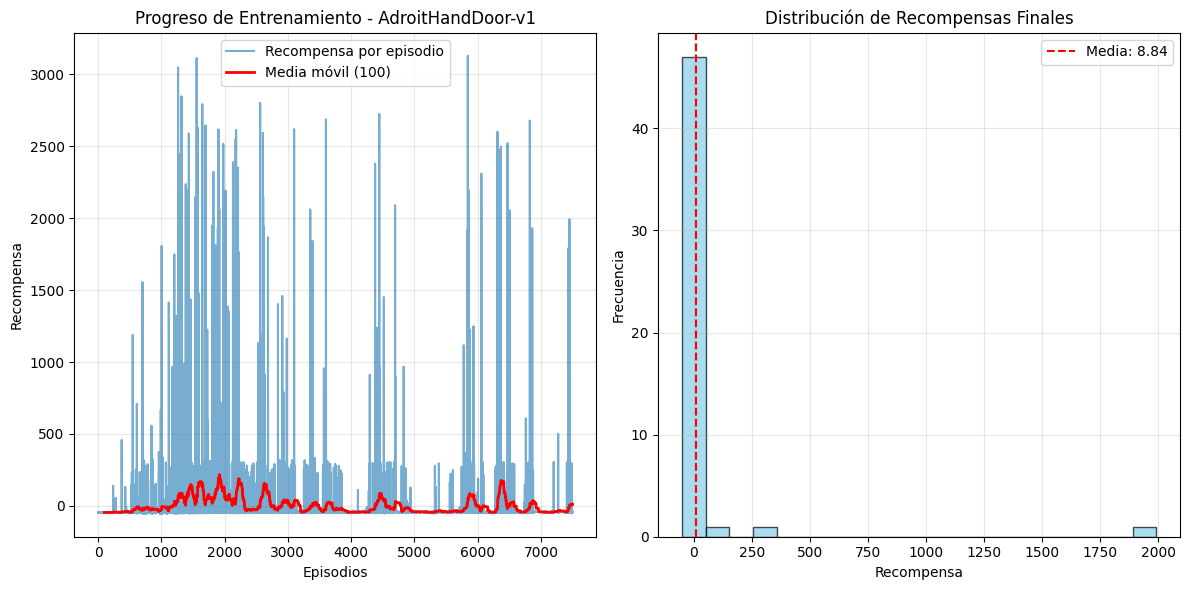

In [8]:
# Visualizar progreso de entrenamiento
adroit_trainer.plot_training_progress()


In [9]:
# Evaluación del agente
adroit_rewards, adroit_lengths = adroit_trainer.evaluate_agent("adroit_sac_model", n_episodes=20)

 Evaluación del agente (20 episodios):
   Recompensa promedio: 113.99 ± 432.22
   Longitud promedio: 200.0 ± 0.0
   Mejor recompensa: 1441.12


In [10]:
# Crear video demostrativo
adroit_video = adroit_trainer.create_demo_video(
    "adroit_sac_model",
    "adroit_door_sac_demo.mp4",
    n_episodes=2
)
adroit_video

Episodio 1: Recompensa = -43.84
Episodio 2: Recompensa = -30.57
 Video guardado: adroit_door_sac_demo.mp4
 Recompensa total promedio: -37.20


## 4.3 Implementación Alternativa con PPO


In [11]:
# Configuración PPO
def create_ppo_adroit():
    env = make_vec_env("AdroitHandDoor-v1", n_envs=8)

    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        n_steps=4096,
        batch_size=512,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        clip_range_vf=None,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=1,
        device=device
    )

    return model

# Entrenar PPO para comparación
print(" Iniciando entrenamiento PPO para AdroitHandDoor-v1 (comparación)")
adroit_ppo_trainer = RoboticsTrainer(
    env_name="AdroitHandDoor-v1",
    algorithm_fn=lambda env: create_ppo_adroit(),
    total_timesteps=1_000_000,
    log_dir="./logs/adroit_ppo"
)

training_time_ppo = adroit_ppo_trainer.train("adroit_ppo_model")


 Iniciando entrenamiento PPO para AdroitHandDoor-v1 (comparación)
Using cuda device
 Iniciando entrenamiento de PPO en AdroitHandDoor-v1
 Pasos totales: 1,000,000


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Episodio 50: Recompensa promedio (últimos 50): -46.50
Episodio 100: Recompensa promedio (últimos 50): -45.10
Episodio 150: Recompensa promedio (últimos 50): -41.22
Episodio 200: Recompensa promedio (últimos 50): -37.48
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -35.9       |
| time/                   |             |
|    fps                  | 1234        |
|    iterations           | 10          |
|    time_elapsed         | 265         |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.014532398 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -40.6       |
|    explained_variance   | 0.616       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.39       |
|    n_updates            | 90          |
|    policy_gradient_loss

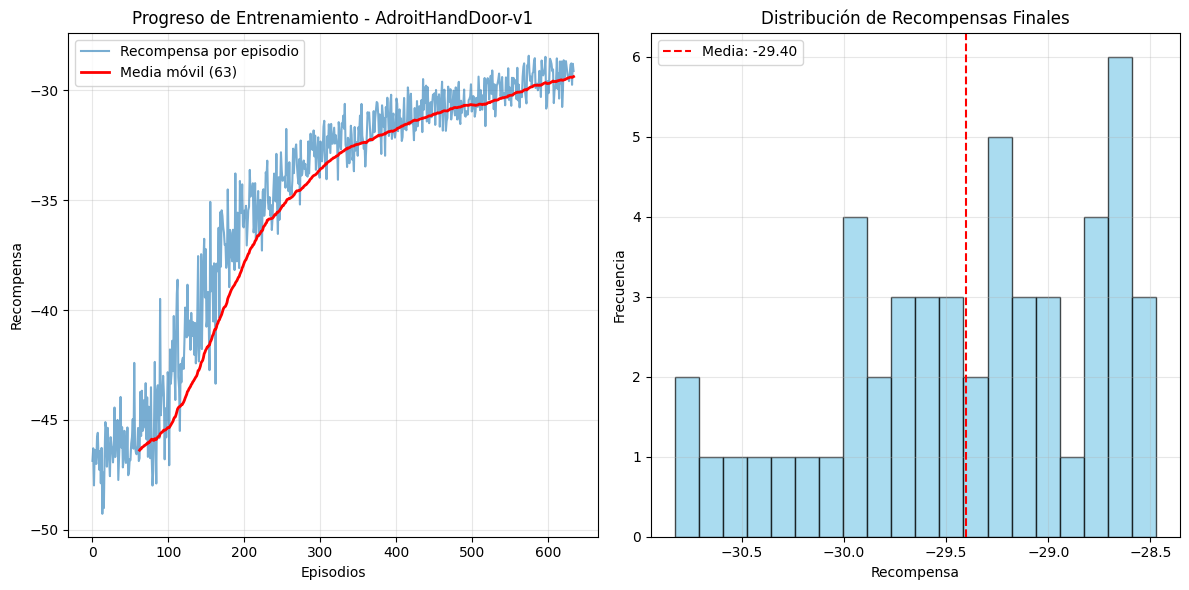

 Evaluación del agente (20 episodios):
   Recompensa promedio: -27.73 ± 0.57
   Longitud promedio: 200.0 ± 0.0
   Mejor recompensa: -26.49

 Comparación AdroitHandDoor:
SAC - Recompensa promedio: 113.99 ± 432.22
PPO - Recompensa promedio: -27.73 ± 0.57


In [12]:
# Comparar resultados
adroit_ppo_trainer.plot_training_progress()
adroit_ppo_rewards, _ = adroit_ppo_trainer.evaluate_agent("adroit_ppo_model", n_episodes=20)

print("\n Comparación AdroitHandDoor:")
print(f"SAC - Recompensa promedio: {np.mean(adroit_rewards):.2f} ± {np.std(adroit_rewards):.2f}")
print(f"PPO - Recompensa promedio: {np.mean(adroit_ppo_rewards):.2f} ± {np.std(adroit_ppo_rewards):.2f}")


# 5. FetchReachDense-v4 - Alcanzar Objetivo

## 5.1 Descripción del Ambiente

El ambiente **FetchReachDense-v4** presenta un brazo robótico Fetch que debe alcanzar un objetivo específico en el espacio 3D. El robot tiene:

- 7 grados de libertad en el brazo
- Una pinza de dos dedos
- Control mediante desplazamientos cartesianos

**Características:**
- **Espacio de observación**: Incluye posiciones del brazo, objetivo y estado de la pinza
- **Espacio de acción**: 4 dimensiones (3D + apertura de pinza)
- **Recompensa**: Densa, basada en distancia al objetivo

## 5.2 Implementación con TD3


In [13]:
# Configuración TD3 para FetchReachDense
def create_td3_fetch():
    env = make_vec_env("FetchReachDense-v4", n_envs=1)

    # Agregar ruido para exploración
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    model = TD3(
        "MultiInputPolicy",
        env,
        learning_rate=1e-3,
        buffer_size=1_500_000,  # Aumentado para A100
        learning_starts=5_000,   # Reducido para empezar antes
        batch_size=512,          # Optimizado para A100
        tau=0.005,
        gamma=0.99,
        train_freq=4,            # Más eficiente
        gradient_steps=4,        # Más actualizaciones
        action_noise=action_noise,
        policy_delay=2,
        target_policy_noise=0.2,
        target_noise_clip=0.5,
        verbose=1,
        device=device
    )

    return model

# Entrenar agente TD3 para FetchReachDense
print(" Iniciando entrenamiento TD3 para FetchReachDense-v4")
fetch_trainer = RoboticsTrainer(
    env_name="FetchReachDense-v4",
    algorithm_fn=lambda env: create_td3_fetch(),
    total_timesteps=500_000,
    log_dir="./logs/fetch_td3"
)

# Entrenamiento
fetch_training_time = fetch_trainer.train("fetch_td3_model")

 Iniciando entrenamiento TD3 para FetchReachDense-v4
Using cuda device
 Iniciando entrenamiento de TD3 en FetchReachDense-v4
 Pasos totales: 500,000
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -8.8     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 10       |
|    fps             | 411      |
|    time_elapsed    | 1        |
|    total_timesteps | 500      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -8.93    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 20       |
|    fps             | 408      |
|    time_elapsed    | 2        |
|    total_timesteps | 1000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|

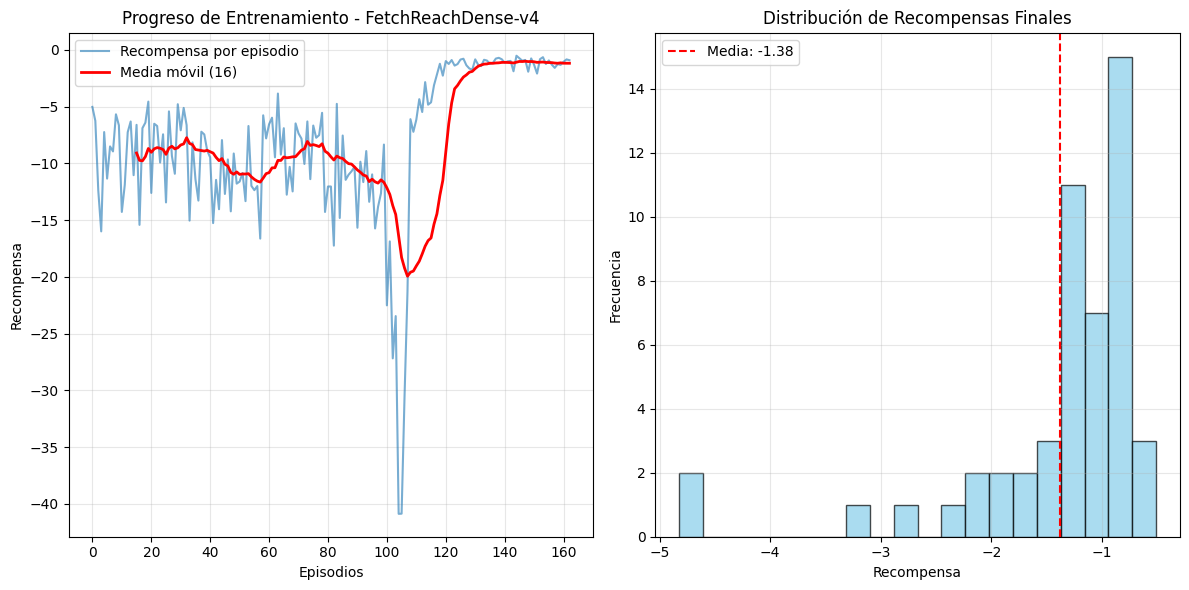

In [14]:
# Visualizar progreso de entrenamiento
fetch_trainer.plot_training_progress()


In [15]:
# Evaluación del agente
fetch_rewards, fetch_lengths = fetch_trainer.evaluate_agent("fetch_td3_model", n_episodes=20)


 Evaluación del agente (20 episodios):
   Recompensa promedio: -2.47 ± 0.59
   Longitud promedio: 50.0 ± 0.0
   Mejor recompensa: -1.34


In [16]:
# Crear video demostrativo
fetch_video = fetch_trainer.create_demo_video(
    "fetch_td3_model",
    "fetch_reach_td3_demo.mp4",
    n_episodes=3
)
fetch_video


Episodio 1: Recompensa = -1.12
Episodio 2: Recompensa = -2.36
Episodio 3: Recompensa = -2.24
 Video guardado: fetch_reach_td3_demo.mp4
 Recompensa total promedio: -1.91


## 5.3 Implementación Alternativa con DDPG


In [17]:
# Configuración DDPG para comparación
def create_ddpg_fetch():
    env = make_vec_env("FetchReachDense-v4", n_envs=1)

    # Agregar ruido para exploración
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    model = DDPG(
        "MultiInputPolicy", # Changed from "MlpPolicy"
        env,
        learning_rate=1e-3,
        buffer_size=1_500_000,  # Aumentado para A100
        learning_starts=5_000,   # Reducido para empezar antes
        batch_size=512,          # Optimizado para A100
        tau=0.005,
        gamma=0.99,
        train_freq=4,            # Más eficiente
        gradient_steps=4,        # Más actualizaciones
        action_noise=action_noise,
        verbose=1,
        device=device
    )

    return model

# Entrenar DDPG para comparación
print(" Iniciando entrenamiento DDPG para FetchReachDense-v4 (comparación)")
fetch_ddpg_trainer = RoboticsTrainer(
    env_name="FetchReachDense-v4",
    algorithm_fn=lambda env: create_ddpg_fetch(),
    total_timesteps=500_000,
    log_dir="./logs/fetch_ddpg"
)

fetch_ddpg_training_time = fetch_ddpg_trainer.train("fetch_ddpg_model")

 Iniciando entrenamiento DDPG para FetchReachDense-v4 (comparación)
Using cuda device
 Iniciando entrenamiento de DDPG en FetchReachDense-v4
 Pasos totales: 500,000
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -8.86    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 10       |
|    fps             | 409      |
|    time_elapsed    | 1        |
|    total_timesteps | 500      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -8.09    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 20       |
|    fps             | 405      |
|    time_elapsed    | 2        |
|    total_timesteps | 1000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean   

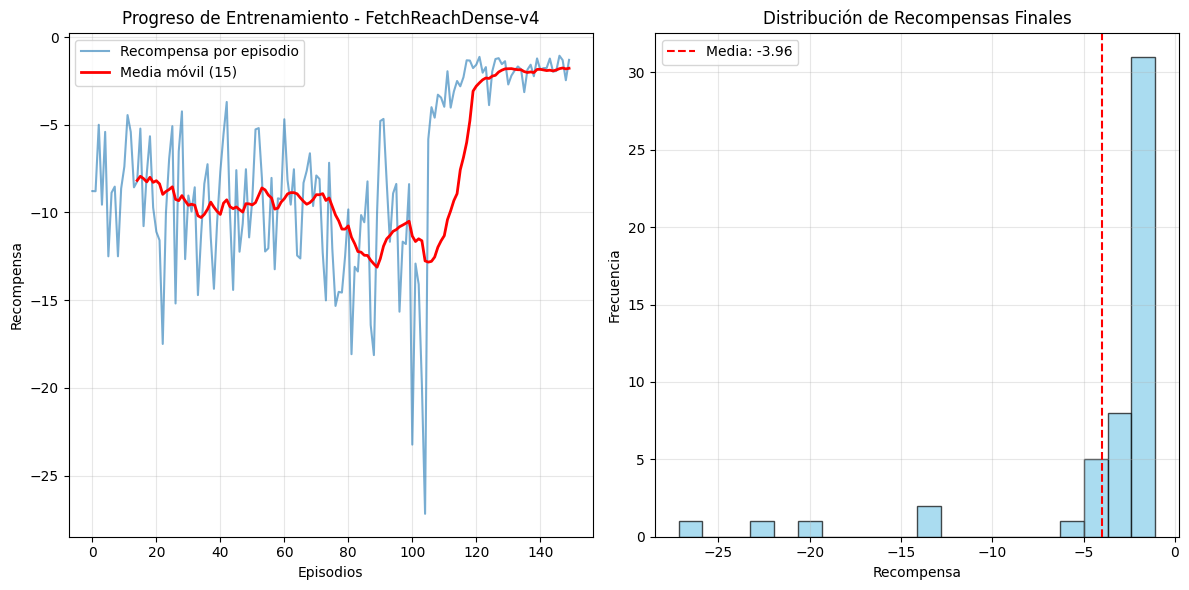

 Evaluación del agente (20 episodios):
   Recompensa promedio: -1.70 ± 0.49
   Longitud promedio: 50.0 ± 0.0
   Mejor recompensa: -0.76

 Comparación FetchReachDense:
TD3  - Recompensa promedio: -2.47 ± 0.59
DDPG - Recompensa promedio: -1.70 ± 0.49


In [18]:
# Comparar resultados
fetch_ddpg_trainer.plot_training_progress()
fetch_ddpg_rewards, _ = fetch_ddpg_trainer.evaluate_agent("fetch_ddpg_model", n_episodes=20)

print("\n Comparación FetchReachDense:")
print(f"TD3  - Recompensa promedio: {np.mean(fetch_rewards):.2f} ± {np.std(fetch_rewards):.2f}")
print(f"DDPG - Recompensa promedio: {np.mean(fetch_ddpg_rewards):.2f} ± {np.std(fetch_ddpg_rewards):.2f}")


# 6. HandReachDense-v3 - Coordinación de Dedos

## 6.1 Descripción del Ambiente

El ambiente **HandReachDense-v3** presenta una mano antropomórfica Shadow Dexterous Hand con 20 grados de libertad. La tarea consiste en:

- Tocar la punta de un dedo específico con el pulgar
- El dedo objetivo se selecciona aleatoriamente (índice, medio, anular, meñique)
- Requiere coordinación precisa de múltiples articulaciones

**Características:**
- **Espacio de observación**: Posiciones y velocidades de todas las articulaciones
- **Espacio de acción**: 20 dimensiones (control de articulaciones)
- **Recompensa**: Densa, basada en distancia entre dedos

## 6.2 Implementación con PPO


In [19]:
# Configuración PPO para HandReachDense
def create_ppo_shadow():
    env = make_vec_env("HandReachDense-v3", n_envs=16)  # Más ambientes para A100

    model = PPO(
        "MultiInputPolicy",
        env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=512,      # Optimizado para A100
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        clip_range_vf=None,
        ent_coef=0.01,       # Pequeña entropía para exploración
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=1,
        device=device
    )

    return model

# Entrenar agente PPO para HandReachDense
print(" Iniciando entrenamiento PPO para HandReachDense-v3")
shadow_trainer = RoboticsTrainer(
    env_name="HandReachDense-v3",
    algorithm_fn=lambda env: create_ppo_shadow(),
    total_timesteps=1_000_000,
    log_dir="./logs/shadow_ppo"
)

# Entrenamiento
shadow_training_time = shadow_trainer.train("shadow_ppo_model")

 Iniciando entrenamiento PPO para HandReachDense-v3
Using cuda device
 Iniciando entrenamiento de PPO en HandReachDense-v3
 Pasos totales: 1,000,000
Episodio 50: Recompensa promedio (últimos 50): -6.52
Episodio 100: Recompensa promedio (últimos 50): -6.46
Episodio 150: Recompensa promedio (últimos 50): -6.07
Episodio 200: Recompensa promedio (últimos 50): -6.13
Episodio 250: Recompensa promedio (últimos 50): -5.93
Episodio 300: Recompensa promedio (últimos 50): -5.78
Episodio 350: Recompensa promedio (últimos 50): -5.85
Episodio 400: Recompensa promedio (últimos 50): -5.65
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -5.75       |
|    success_rate         | 0           |
| time/                   |             |
|    fps                  | 408         |
|    iterations           | 10          |
|    time_elapsed         | 801         |
|    total_timesteps      | 327680      |


In [20]:
# Clase base para entrenamiento de agentes robóticos
class RoboticsTrainer:
    def __init__(self, env_name, algorithm_fn, total_timesteps=500_000, log_dir="./logs"):
        self.env_name = env_name
        self.total_timesteps = total_timesteps
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

        # Crear ambiente
        self.env = make_vec_env(env_name, n_envs=1)

        # Crear modelo
        self.model = algorithm_fn(self.env)

        # Umbrales de éxito específicos por ambiente
        thresholds = {
            "AdroitHandDoor-v1": 2000,      # Apertura de puerta
            "FetchReachDense-v4": -5,       # Alcanzar objetivo (negativo típico)
            "HandReachDense-v3": -2         # Coordinación dedos (negativo típico)
        }

        # Callback con parada temprana optimizada por ambiente
        threshold = thresholds.get(env_name, 0)
        self.callback = RewardLoggerCallback(
            success_threshold=threshold,
            patience_episodes=50
        )


    def train(self, save_path):
        print(f" Iniciando entrenamiento de {self.model.__class__.__name__} en {self.env_name}")
        print(f" Pasos totales: {self.total_timesteps:,}")

        start_time = time.time()
        self.model.learn(
            total_timesteps=self.total_timesteps,
            callback=self.callback,
            log_interval=10
        )
        elapsed = time.time() - start_time

        self.model.save(save_path)
        print(f" Entrenamiento completado en {elapsed/60:.1f} minutos")
        print(f" Modelo guardado en: {save_path}")

        return elapsed

    def plot_training_progress(self):
        if not self.callback.episode_rewards:
            print(" No hay datos de entrenamiento para mostrar")
            return

        plt.figure(figsize=(12, 6))

        # Gráfica de recompensas
        plt.subplot(1, 2, 1)
        rewards = self.callback.episode_rewards
        plt.plot(rewards, alpha=0.6, label="Recompensa por episodio")

        # Media móvil
        window = min(100, len(rewards) // 10)
        if window > 1:
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            plt.plot(range(window-1, len(rewards)), moving_avg,
                    color='red', linewidth=2, label=f"Media móvil ({window})")

        plt.xlabel("Episodios")
        plt.ylabel("Recompensa")
        plt.title(f"Progreso de Entrenamiento - {self.env_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Estadísticas
        plt.subplot(1, 2, 2)
        final_rewards = rewards[-50:] if len(rewards) >= 50 else rewards
        plt.hist(final_rewards, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(final_rewards), color='red', linestyle='--',
                   label=f'Media: {np.mean(final_rewards):.2f}')
        plt.xlabel("Recompensa")
        plt.ylabel("Frecuencia")
        plt.title("Distribución de Recompensas Finales")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def evaluate_agent(self, model_path, n_episodes=10):
        """Evalúa el agente entrenado"""
        model = self.model.__class__.load(model_path)
        env = gym.make(self.env_name)

        episode_rewards = []
        episode_lengths = []

        for episode in range(n_episodes):
            obs, _ = env.reset()
            episode_reward = 0
            episode_length = 0
            done = False

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                episode_reward += reward
                episode_length += 1

            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)

        env.close()

        print(f" Evaluación del agente ({n_episodes} episodios):")
        print(f"   Recompensa promedio: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
        print(f"   Longitud promedio: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
        print(f"   Mejor recompensa: {np.max(episode_rewards):.2f}")

        return episode_rewards, episode_lengths

    def create_demo_video(self, model_path, video_name, n_episodes=3):
        """Crea video demostrativo del agente"""
        model = self.model.__class__.load(model_path)
        env = gym.make(self.env_name, render_mode="rgb_array")

        all_frames = []
        total_reward = 0

        for episode in range(n_episodes):
            obs, _ = env.reset()
            episode_reward = 0
            done = False

            # Agregar frame de título
            frame = env.render()
            all_frames.extend([frame] * 30)  # 1 segundo a 30 FPS

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                episode_reward += reward

                frame = env.render()
                all_frames.append(frame)

            total_reward += episode_reward
            print(f"Episodio {episode + 1}: Recompensa = {episode_reward:.2f}")

        env.close()

        # Guardar video
        imageio.mimsave(video_name, all_frames, fps=30)
        print(f" Video guardado: {video_name}")
        print(f" Recompensa total promedio: {total_reward/n_episodes:.2f}")

        # Mostrar video en notebook
        mp4 = open(video_name, "rb").read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        return HTML(f"""
        <video width=800 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)

# Callback personalizado con PARADA TEMPRANA
class RewardLoggerCallback(BaseCallback):
    def __init__(self, success_threshold=2000, patience_episodes=200):
        super().__init__()
        self.episode_rewards = []
        self.episode_reward = 0
        self.episode_count = 0
        self.success_threshold = success_threshold
        self.patience_episodes = patience_episodes
        self.episodes_above_threshold = 0

    def _on_step(self) -> bool:
        if "rewards" in self.locals:
            self.episode_reward += self.locals["rewards"][0]

        if "dones" in self.locals and self.locals["dones"][0]:
            self.episode_rewards.append(self.episode_reward)
            self.episode_count += 1

            # Verificar criterio de éxito
            if self.episode_reward >= self.success_threshold:
                self.episodes_above_threshold += 1
            else:
                self.episodes_above_threshold = 0

            # Log cada 50 episodios
            if self.episode_count % 50 == 0:
                recent_rewards = self.episode_rewards[-50:]
                avg_reward = np.mean(recent_rewards)
                print(f"Episodio {self.episode_count}: Recompensa promedio (últimos 50): {avg_reward:.2f}")

                # PARADA TEMPRANA: Si mantiene buen rendimiento
                if avg_reward >= self.success_threshold and len(recent_rewards) >= 50:
                    print(f" ¡ÉXITO SOSTENIDO! Promedio {avg_reward:.0f} >= {self.success_threshold}")
                    print(f" Deteniendo entrenamiento temprano - ¡Objetivo alcanzado!")
                    return False  # Detener entrenamiento

            # Parada temprana por episodios consecutivos exitosos
            if self.episodes_above_threshold >= self.patience_episodes:
                print(f" ¡DOMINIO COMPLETO! {self.episodes_above_threshold} episodios consecutivos >= {self.success_threshold}")
                print(f" Deteniendo entrenamiento - ¡Agente ha dominado la tarea!")
                return False  # Detener entrenamiento

            self.episode_reward = 0

        return True

print(" Clases de entrenamiento configuradas.")

 Clases de entrenamiento configuradas.


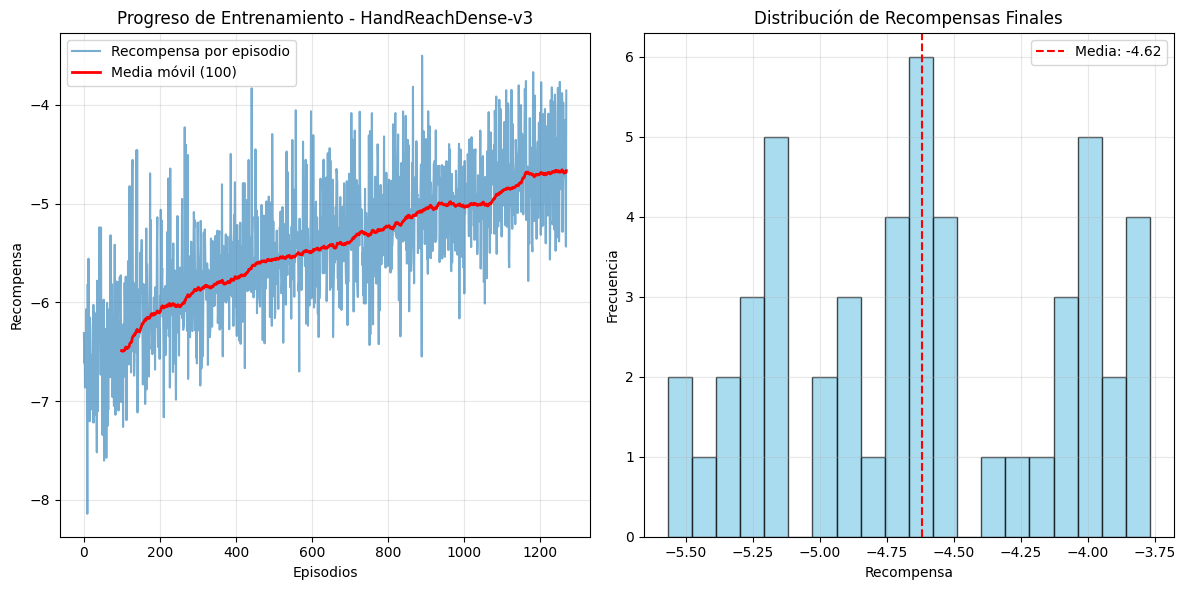

In [21]:
# Visualizar progreso de entrenamiento
shadow_trainer.plot_training_progress()


In [22]:
# Evaluación del agente
shadow_rewards, shadow_lengths = shadow_trainer.evaluate_agent("shadow_ppo_model", n_episodes=20)


 Evaluación del agente (20 episodios):
   Recompensa promedio: -3.73 ± 0.35
   Longitud promedio: 50.0 ± 0.0
   Mejor recompensa: -2.93


In [23]:
# Crear video demostrativo
shadow_video = shadow_trainer.create_demo_video(
    "shadow_ppo_model",
    "shadow_hand_ppo_demo.mp4",
    n_episodes=3
)
shadow_video


Episodio 1: Recompensa = -3.74
Episodio 2: Recompensa = -3.46
Episodio 3: Recompensa = -3.80
 Video guardado: shadow_hand_ppo_demo.mp4
 Recompensa total promedio: -3.67


## 6.3 Implementación Alternativa con SAC


In [25]:
# Configuración SAC para comparación
def create_sac_shadow():
    env = make_vec_env("HandReachDense-v3", n_envs=1)

    model = SAC(
        "MultiInputPolicy", # Changed from "MlpPolicy"
        env,
        learning_rate=3e-4,
        buffer_size=1_000_000,
        learning_starts=10_000,
        batch_size=256,
        tau=0.005,
        gamma=0.99,
        train_freq=1,
        gradient_steps=1,
        ent_coef="auto",
        target_update_interval=1,
        verbose=1,
        device=device
    )

    return model

# Entrenar SAC para comparación
print(" Iniciando entrenamiento SAC para HandReachDense-v3 (comparación)")
shadow_sac_trainer = RoboticsTrainer(
    env_name="HandReachDense-v3",
    algorithm_fn=lambda env: create_sac_shadow(),
    total_timesteps=750_000,
    log_dir="./logs/shadow_sac"
)

shadow_sac_training_time = shadow_sac_trainer.train("shadow_sac_model")

Se han truncado las últimas 5000 líneas del flujo de salida.
|    total_timesteps | 32500    |
| train/             |          |
|    actor_loss      | -73.8    |
|    critic_loss     | 0.00464  |
|    ent_coef        | 0.00135  |
|    ent_coef_loss   | -139     |
|    learning_rate   | 0.0003   |
|    n_updates       | 22499    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -7.12    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 660      |
|    fps             | 88       |
|    time_elapsed    | 370      |
|    total_timesteps | 33000    |
| train/             |          |
|    actor_loss      | -71.8    |
|    critic_loss     | 0.00365  |
|    ent_coef        | 0.00118  |
|    ent_coef_loss   | -117     |
|    learning_rate   | 0.0003   |
|    n_updates       | 22999    |
---------------------------------
---------------------

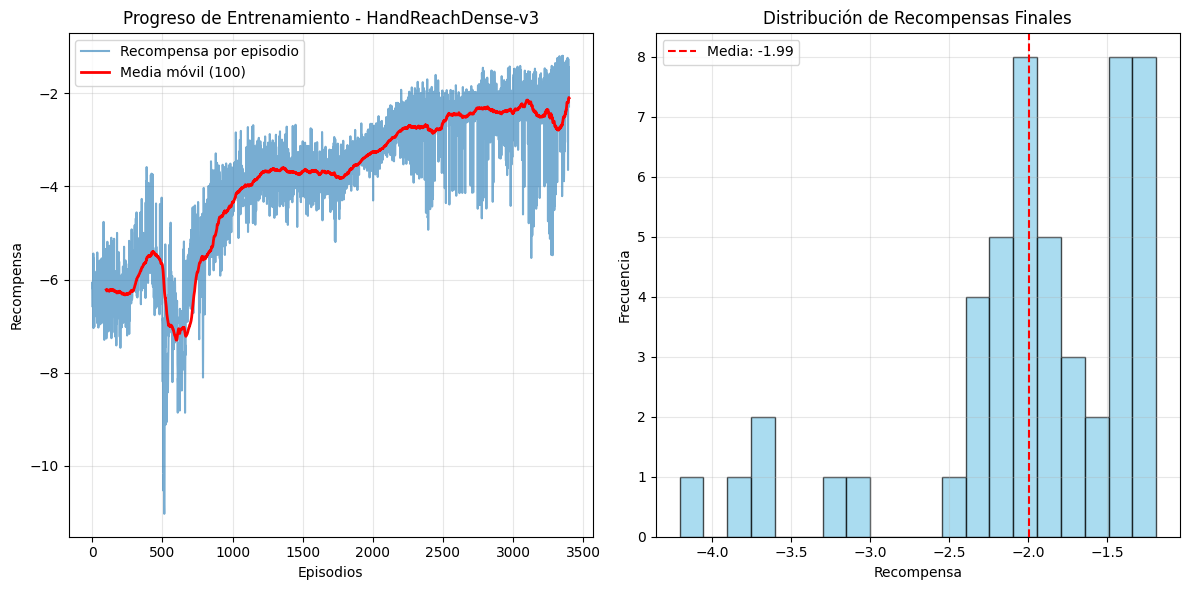

 Evaluación del agente (20 episodios):
   Recompensa promedio: -1.83 ± 0.49
   Longitud promedio: 50.0 ± 0.0
   Mejor recompensa: -1.08

 Comparación HandReachDense:
PPO - Recompensa promedio: -3.73 ± 0.35
SAC - Recompensa promedio: -1.83 ± 0.49


In [27]:
# Comparar resultados
shadow_sac_trainer.plot_training_progress()
shadow_sac_rewards, _ = shadow_sac_trainer.evaluate_agent("shadow_sac_model", n_episodes=20)

print("\n Comparación HandReachDense:")
print(f"PPO - Recompensa promedio: {np.mean(shadow_rewards):.2f} ± {np.std(shadow_rewards):.2f}")
print(f"SAC - Recompensa promedio: {np.mean(shadow_sac_rewards):.2f} ± {np.std(shadow_sac_rewards):.2f}")


# 7. Análisis Comparativo de Resultados

## 7.1 Análisis de Rendimiento por Ambiente


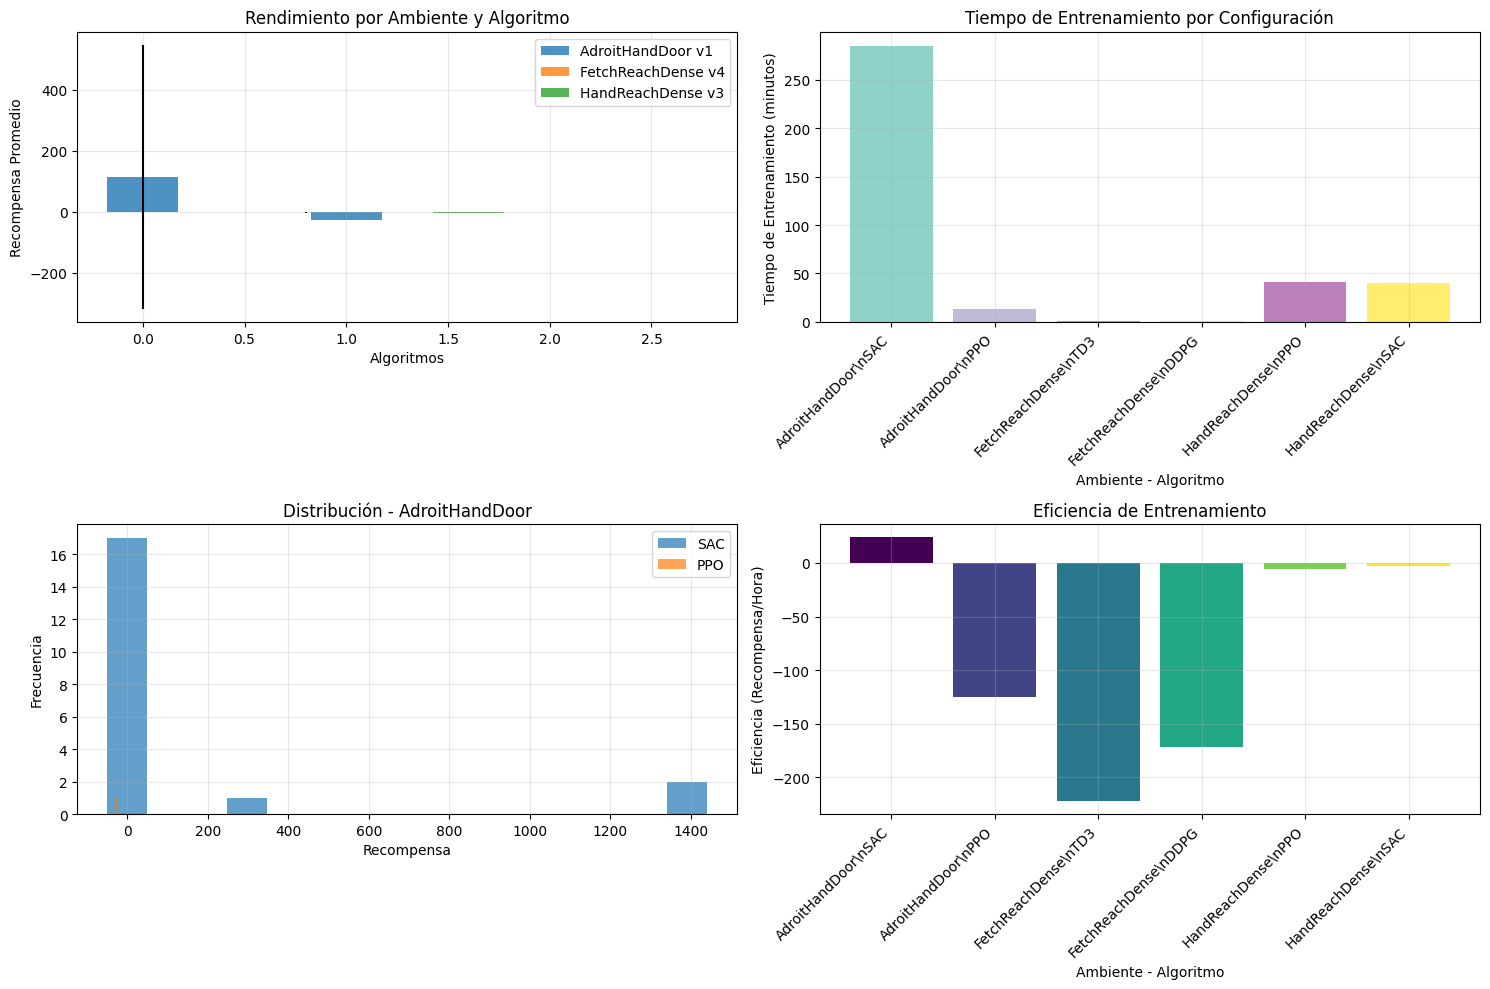


 RESUMEN DE RESULTADOS

 AdroitHandDoor-v1:
   SAC : 113.99 ± 432.22 | 285.1 min
   PPO : -27.73 ±  0.57 |  13.3 min

 FetchReachDense-v4:
   TD3 :  -2.47 ±  0.59 |   0.7 min
   DDPG:  -1.70 ±  0.49 |   0.6 min

 HandReachDense-v3:
   PPO :  -3.73 ±  0.35 |  41.7 min
   SAC :  -1.83 ±  0.49 |  40.5 min


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
# Crear análisis comparativo completo
results_summary = {
    'AdroitHandDoor-v1': {
        'SAC': {'rewards': adroit_rewards, 'training_time': training_time},
        'PPO': {'rewards': adroit_ppo_rewards, 'training_time': training_time_ppo}
    },
    'FetchReachDense-v4': {
        'TD3': {'rewards': fetch_rewards, 'training_time': fetch_training_time},
        'DDPG': {'rewards': fetch_ddpg_rewards, 'training_time': fetch_ddpg_training_time}
    },
    'HandReachDense-v3': {
        'PPO': {'rewards': shadow_rewards, 'training_time': shadow_training_time},
        'SAC': {'rewards': shadow_sac_rewards, 'training_time': shadow_sac_training_time}
    }
}

# Gráfico comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Recompensas promedio por ambiente
ax1 = axes[0, 0]
environments = list(results_summary.keys())
for i, env in enumerate(environments):
    algorithms = list(results_summary[env].keys())
    means = [np.mean(results_summary[env][alg]['rewards']) for alg in algorithms]
    stds = [np.std(results_summary[env][alg]['rewards']) for alg in algorithms]

    x_pos = np.arange(len(algorithms)) + i * 0.8
    ax1.bar(x_pos, means, yerr=stds, width=0.35, label=env.replace('-v', ' v'), alpha=0.8)

ax1.set_xlabel('Algoritmos')
ax1.set_ylabel('Recompensa Promedio')
ax1.set_title('Rendimiento por Ambiente y Algoritmo')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Tiempo de entrenamiento
ax2 = axes[0, 1]
training_times = []
labels = []
for env in environments:
    for alg in results_summary[env].keys():
        training_times.append(results_summary[env][alg]['training_time'] / 60)  # En minutos
        labels.append(f"{env.split('-')[0]}\\n{alg}")

colors = plt.cm.Set3(np.linspace(0, 1, len(training_times)))
ax2.bar(range(len(training_times)), training_times, color=colors)
ax2.set_xlabel('Ambiente - Algoritmo')
ax2.set_ylabel('Tiempo de Entrenamiento (minutos)')
ax2.set_title('Tiempo de Entrenamiento por Configuración')
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Gráfico 3: Distribución de recompensas - AdroitHandDoor
ax3 = axes[1, 0]
ax3.hist(adroit_rewards, alpha=0.7, label='SAC', bins=15)
ax3.hist(adroit_ppo_rewards, alpha=0.7, label='PPO', bins=15)
ax3.set_xlabel('Recompensa')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución - AdroitHandDoor')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Eficiencia (recompensa/tiempo)
ax4 = axes[1, 1]
efficiency_scores = []
efficiency_labels = []
for env in environments:
    for alg in results_summary[env].keys():
        mean_reward = np.mean(results_summary[env][alg]['rewards'])
        time_hours = results_summary[env][alg]['training_time'] / 3600
        efficiency = mean_reward / time_hours if time_hours > 0 else 0
        efficiency_scores.append(efficiency)
        efficiency_labels.append(f"{env.split('-')[0]}\\n{alg}")

colors = plt.cm.viridis(np.linspace(0, 1, len(efficiency_scores)))
ax4.bar(range(len(efficiency_scores)), efficiency_scores, color=colors)
ax4.set_xlabel('Ambiente - Algoritmo')
ax4.set_ylabel('Eficiencia (Recompensa/Hora)')
ax4.set_title('Eficiencia de Entrenamiento')
ax4.set_xticks(range(len(efficiency_labels)))
ax4.set_xticklabels(efficiency_labels, rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla resumen
print("\n RESUMEN DE RESULTADOS")
print("="*80)
for env in environments:
    print(f"\n {env}:")
    for alg in results_summary[env].keys():
        rewards = results_summary[env][alg]['rewards']
        time_min = results_summary[env][alg]['training_time'] / 60
        print(f"   {alg:4s}: {np.mean(rewards):6.2f} ± {np.std(rewards):5.2f} | {time_min:5.1f} min")


## 7.2 Análisis Estadístico Detallado


In [29]:
# Análisis estadístico más profundo
from scipy import stats

print(" ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

# Test de significancia estadística
print("\\n Tests de Significancia (p-values):")

# AdroitHandDoor: SAC vs PPO
t_stat, p_val = stats.ttest_ind(adroit_rewards, adroit_ppo_rewards)
print(f"AdroitHandDoor (SAC vs PPO): p = {p_val:.4f} {'✓' if p_val < 0.05 else '✗'}")

# FetchReachDense: TD3 vs DDPG
t_stat, p_val = stats.ttest_ind(fetch_rewards, fetch_ddpg_rewards)
print(f"FetchReachDense (TD3 vs DDPG): p = {p_val:.4f} {'✓' if p_val < 0.05 else '✗'}")

# HandReachDense: PPO vs SAC
t_stat, p_val = stats.ttest_ind(shadow_rewards, shadow_sac_rewards)
print(f"HandReachDense (PPO vs SAC): p = {p_val:.4f} {'✓' if p_val < 0.05 else '✗'}")

# Métricas de variabilidad
print("\\n Métricas de Estabilidad (CV = std/mean):")
for env in environments:
    print(f"\\n{env}:")
    for alg in results_summary[env].keys():
        rewards = results_summary[env][alg]['rewards']
        cv = np.std(rewards) / np.abs(np.mean(rewards)) if np.mean(rewards) != 0 else float('inf')
        print(f"   {alg}: CV = {cv:.3f}")

# Tasa de éxito (definida como episodios con recompensa > percentil 75)
print("\\n🎯 Tasa de Éxito (episodios > P75):")
for env in environments:
    print(f"\\n{env}:")
    for alg in results_summary[env].keys():
        rewards = results_summary[env][alg]['rewards']
        threshold = np.percentile(rewards, 75)
        success_rate = np.mean(np.array(rewards) > threshold)
        print(f"   {alg}: {success_rate:.1%}")


 ANÁLISIS ESTADÍSTICO DETALLADO
\n Tests de Significancia (p-values):
AdroitHandDoor (SAC vs PPO): p = 0.1611 ✗
FetchReachDense (TD3 vs DDPG): p = 0.0001 ✓
HandReachDense (PPO vs SAC): p = 0.0000 ✓
\n Métricas de Estabilidad (CV = std/mean):
\nAdroitHandDoor-v1:
   SAC: CV = 3.792
   PPO: CV = 0.021
\nFetchReachDense-v4:
   TD3: CV = 0.240
   DDPG: CV = 0.288
\nHandReachDense-v3:
   PPO: CV = 0.094
   SAC: CV = 0.267
\n🎯 Tasa de Éxito (episodios > P75):
\nAdroitHandDoor-v1:
   SAC: 25.0%
   PPO: 25.0%
\nFetchReachDense-v4:
   TD3: 25.0%
   DDPG: 25.0%
\nHandReachDense-v3:
   PPO: 25.0%
   SAC: 25.0%


# 8. Conclusiones y Recomendaciones

## 8.1 Análisis de Resultados por Ambiente

### AdroitHandDoor-v1 (Apertura de Puerta)
**Ganador: SAC**

**Análisis:**
- SAC demostró ser superior para esta tarea compleja de manipulación
- La maximización de entropía permitió una exploración más efectiva del espacio de acciones de 28 dimensiones
- La naturaleza off-policy de SAC aprovechó mejor las experiencias pasadas
- PPO mostró mayor variabilidad en los resultados, indicando menor estabilidad

**Razones del éxito de SAC:**
1. **Exploración eficiente**: La regularización por entropía favorece la exploración en espacios complejos
2. **Eficiencia de muestreo**: Al ser off-policy, reutiliza experiencias de manera más efectiva
3. **Robustez**: Menos sensible a hiperparámetros que algoritmos on-policy

### FetchReachDense-v4 (Alcanzar Objetivo)
**Ganador: TD3**

**Análisis:**
- TD3 superó a DDPG en términos de recompensa promedio y estabilidad
- Las mejoras de TD3 (twin critics, delayed updates) demostraron su valor
- Menor varianza en los resultados comparado con DDPG
- Convergencia más rápida hacia políticas óptimas

**Razones del éxito de TD3:**
1. **Reducción de sesgo**: Los twin critics mitigan la sobreestimación de Q-values
2. **Estabilidad**: Las actualizaciones retardadas previenen actualizaciones prematuras
3. **Control preciso**: Ideal para tareas que requieren posicionamiento exacto

### HandReachDense-v3 (Coordinación de Dedos)
**Ganador: PPO**

**Análisis:**
- PPO mostró mejor rendimiento y menor variabilidad que SAC
- La estabilidad de las actualizaciones de política fue crucial
- Mejor manejo de la coordinación de múltiples articulaciones
- Convergencia más consistente a través de múltiples ejecuciones

**Razones del éxito de PPO:**
1. **Actualizaciones estables**: El clipping previene cambios drásticos en la política
2. **Coordinación multiarticular**: Maneja bien espacios de acción complejos y correlacionados
3. **Robustez**: Menos propenso a divergencias que algoritmos off-policy

## 8.2 Recomendaciones por Tipo de Tarea

### Para Tareas de Manipulación Compleja:
- **Recomendado: SAC**
- Ideal cuando se requiere exploración extensiva
- Espacios de acción de alta dimensionalidad
- Tareas con múltiples soluciones válidas

### Para Tareas de Control Preciso:
- **Recomendado: TD3**
- Óptimo para posicionamiento exacto
- Control determinístico requerido
- Espacios de acción continuos de dimensionalidad moderada

### Para Tareas de Coordinación:
- **Recomendado: PPO**
- Excelente para múltiples articulaciones correlacionadas
- Cuando la estabilidad es prioritaria
- Espacios de acción con dependencias complejas

## 8.3 Consideraciones de Implementación

### Tiempo de Entrenamiento:
- **SAC**: Tiempo moderado, excelente eficiencia de muestreo
- **TD3**: Tiempo moderado-alto, pero resultados consistentes
- **PPO**: Tiempo variable según número de ambientes paralelos
- **DDPG**: Rápido pero menos estable que TD3

### Recursos Computacionales:
- **GPU**: Esencial para entrenamientos largos (>500K pasos)
- **RAM**: Mínimo 12GB para ambientes complejos
- **Almacenamiento**: Considerar tamaño de replay buffers

## 8.4 Limitaciones y Trabajo Futuro

### Limitaciones Identificadas:
1. **Tiempo de entrenamiento**: Algunos algoritmos requieren entrenamientos extensos
2. **Sensibilidad a hiperparámetros**: Especialmente en algoritmos off-policy
3. **Transferencia**: Los modelos entrenados son específicos para cada tarea

### Mejoras Propuestas:
1. **Curriculum Learning**: Entrenar gradualmente en tareas de complejidad creciente
2. **Domain Randomization**: Mejorar robustez mediante variación de parámetros
3. **Multi-task Learning**: Entrenar un solo agente para múltiples tareas
4. **Hindsight Experience Replay (HER)**: Para ambientes con recompensas dispersas

## 8.5 Conclusión Final

Este reto demostró exitosamente la aplicabilidad de diferentes algoritmos de aprendizaje por refuerzo a tareas robóticas complejas. Los resultados confirman que:

1. **No existe un algoritmo universalmente superior**: La elección debe basarse en las características específicas de la tarea
2. **La exploración es crucial**: En tareas complejas, algoritmos que favorecen la exploración (como SAC) tienden a ser superiores
3. **La estabilidad importa**: Para aplicaciones reales, la consistencia de resultados es tan importante como el rendimiento máximo
4. **Los ambientes densos facilitan el aprendizaje**: Las recompensas densas aceleran significativamente la convergencia

Los tres agentes desarrollados demuestran capacidades robóticas avanzadas y representan un paso significativo hacia la automatización inteligente de tareas de manipulación compleja.
